In [631]:
import pandas as pd
from dateutil.relativedelta import *
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score, mean_squared_error
import math
import matplotlib.pyplot as plt
import pypyodbc as podbc
from sqlalchemy import create_engine
import urllib

In [632]:
connet2db = podbc.connect("Driver={SQL Server Native Client 11.0};"
                     "Server=DESKTOP-ES9JH7P;"
                     "Database=SharpParts9;"
                     "Trusted_Connection=yes;")

In [633]:
data = pd.read_sql_query('''SELECT * FROM [dbo].[monthly_sales_data]''', connet2db)

In [634]:
data

,month,toyota,honda
0,1964-01-01,2815,2813
1,1964-02-01,2672,2670
2,1964-03-01,2755,2753
3,1964-04-01,2721,2719
4,1964-05-01,2946,2944
...,...,...,...
100,1972-05-01,4618,4616
101,1972-06-01,5312,5310
102,1972-07-01,4298,4296
103,1972-08-01,1413,1411


In [635]:
data.dtypes

month     datetime64[ns]
toyota             int64
honda              int64
dtype: object

In [636]:
# data["month"] = data["month"].apply(lambda x: datetime.strptime(x, "%Y-%m"))
data.set_index("month", inplace=True)

In [637]:
data

,toyota,honda
month,,
1964-01-01,2815,2813
1964-02-01,2672,2670
1964-03-01,2755,2753
1964-04-01,2721,2719
1964-05-01,2946,2944
...,...,...
1972-05-01,4618,4616
1972-06-01,5312,5310
1972-07-01,4298,4296


In [638]:
data.shape

(105, 2)

In [639]:
data.dtypes

toyota    int64
honda     int64
dtype: object

In [640]:
data

,toyota,honda
month,,
1964-01-01,2815,2813
1964-02-01,2672,2670
1964-03-01,2755,2753
1964-04-01,2721,2719
1964-05-01,2946,2944
...,...,...
1972-05-01,4618,4616
1972-06-01,5312,5310
1972-07-01,4298,4296


In [641]:
data["honda"]

month
1964-01-01    2813
1964-02-01    2670
1964-03-01    2753
1964-04-01    2719
1964-05-01    2944
              ... 
1972-05-01    4616
1972-06-01    5310
1972-07-01    4296
1972-08-01    1411
1972-09-01    5875
Name: honda, Length: 105, dtype: int64

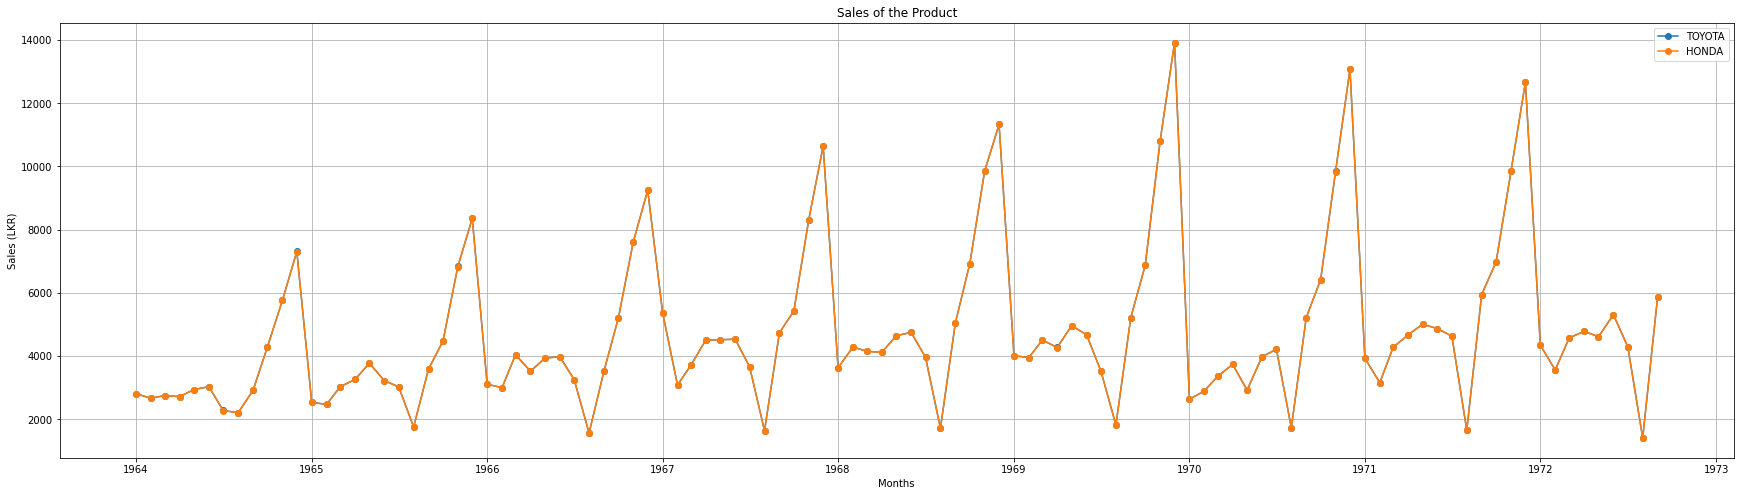

In [656]:
plt.figure(figsize=(30, 8))
for column in data.columns:
    plt.plot(data[column], marker="o", label=column.upper())
plt.title("Sales of the Product")
plt.xlabel("Months")
plt.ylabel("Sales (LKR)")
plt.grid()
plt.legend()
plt.show()

In [643]:
adf_test = ADFTest()
for column in data.columns:
    print(adf_test.should_diff(data[column]))

(0.01, False)
(0.01, False)


In [644]:
def split_train_test(training_sample_count, data, plot=True):
    train = data[:training_sample_count]
    test = data[training_sample_count:]
    if plot:
        plt.plot(train)
        plt.plot(test)
    
    return train, test


In [645]:
def train_arima(training_data, summary=True):
    arima_model = auto_arima(
        training_data,
        start_p=0, d=1, start_q=0,
        max_p=5, max_d=5, max_q=5,
        start_P=0, D=1, start_Q=0, 
        max_P=0, max_D=5, max_Q=5,
        m=12, seasonal=True,
    )
    if summary:
        print(arima_model.summary())
    
    return arima_model

In [646]:
def predict(arima_model, prediction_period, index):
    return pd.DataFrame(arima_model.predict(n_periods=prediction_period), index=index)

In [ ]:
quoted = urllib.parse.quote_plus("Driver={SQL Server Native Client 11.0};"
                     "Server=DESKTOP-ES9JH7P;"
                     "Database=SharpParts9;"
                     "Trusted_Connection=yes;")

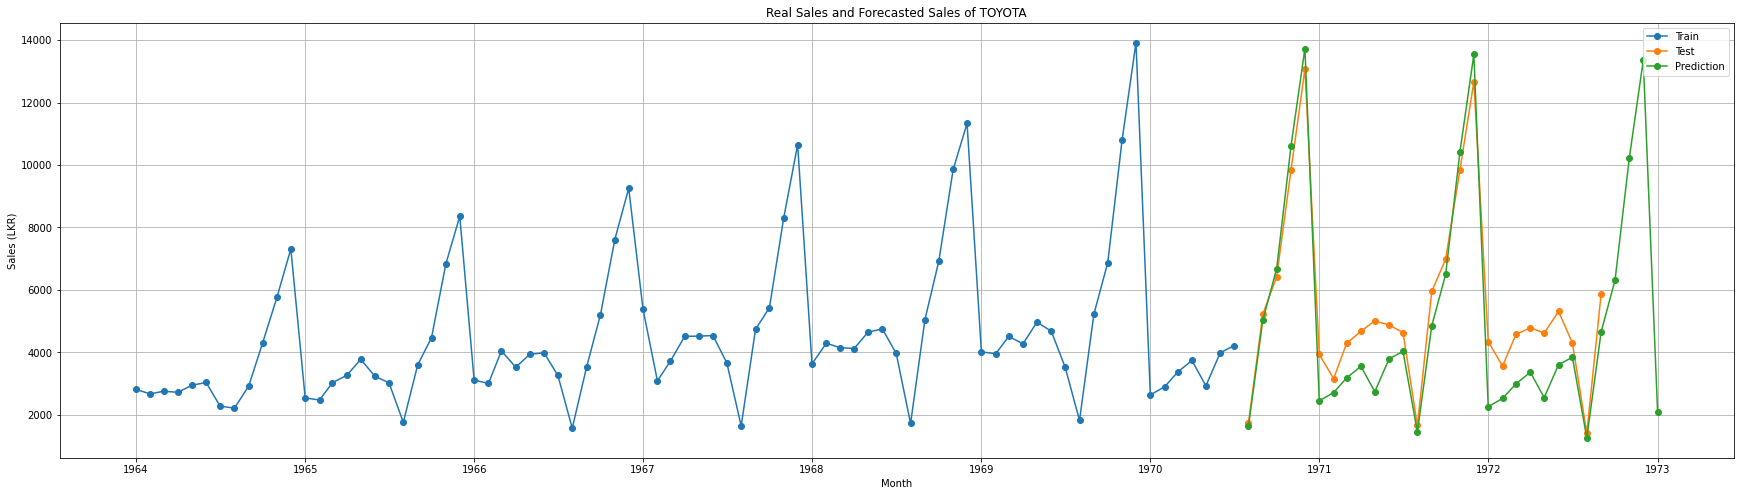

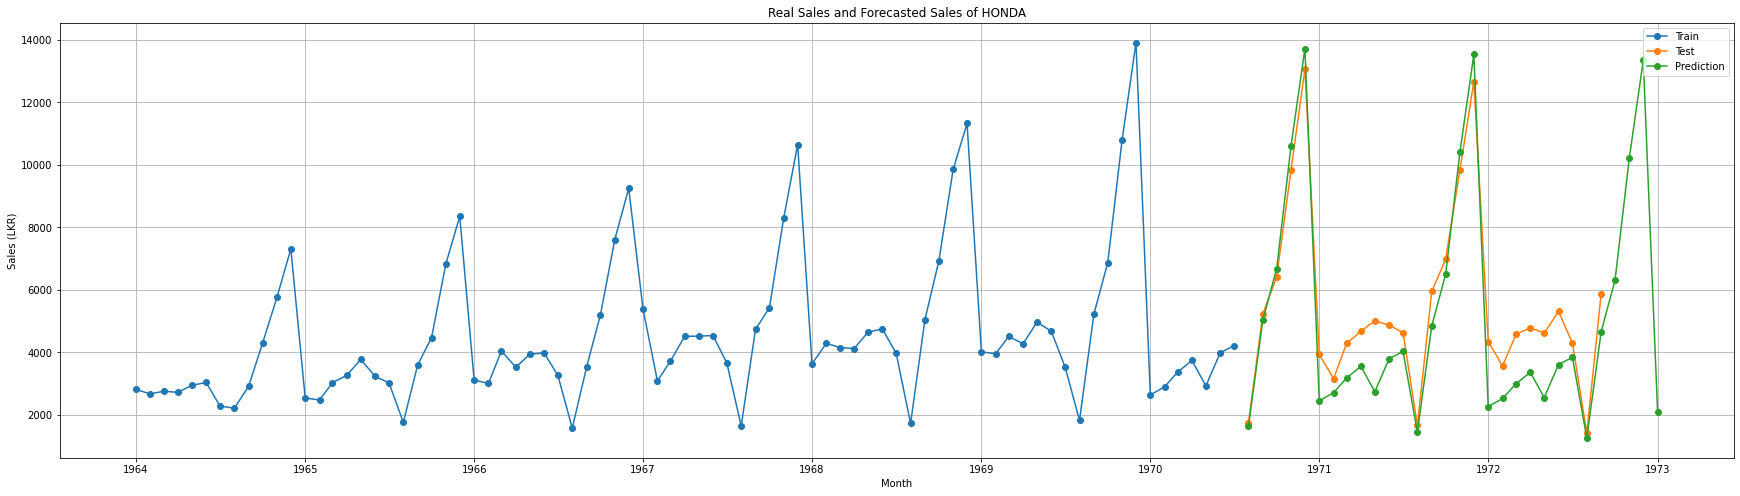

In [655]:
for column in data.columns:
    training_sample_count = round(data.shape[0] * 0.75)
    train, test = split_train_test(training_sample_count, data[column], plot=False)
    model = train_arima(train, summary=False)
    # prediction_period = data.shape[0] - training_sample_count
    prediction_period = 30
    index = pd.date_range(train.index[-1] + relativedelta(months=1), periods=prediction_period, freq='MS')
    prediction = predict(model, prediction_period, index)

    engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

    prediction.to_sql(f'{column}', schema='dbo', con = engine, if_exists = 'replace')

    plt.figure(figsize=(30, 8))
    plt.plot(train, marker="o", label="Train")
    plt.plot(test, marker="o", label="Test")
    plt.plot(prediction, marker="o", label="Prediction")
    plt.title(f"Real Sales and Forecasted Sales of {column.upper()}")
    plt.xlabel("Month")
    plt.ylabel("Sales (LKR)")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()